In [2]:
import numpy as np
import pandas as pd 
from pandas import Series, DataFrame
import matplotlib.pyplot as plt
import uproot
from scipy import stats
from scipy.optimize import curve_fit
from scipy.special import comb
from scipy.stats import chi2
from scipy.special import comb
from scipy.optimize import lsq_linear
import math
import sys
import os 
from plot_tools import *
from customStats import *
#import tools
import common_tools
# from selection_cuts import selection_nominal
import mplhep as hep
from sklearn.model_selection import train_test_split
plt.style.use(hep.style.CMS)
plt.rcParams['figure.figsize'] = [10,8]
plt.rcParams['font.size'] = 24
plt.figure()
plt.close()
plt.rcParams.update({'figure.figsize':[10,8]})
plt.rcParams.update({'font.size':24})
### E F F I C I E N C Y 
import tensorflow as tf
import math
import zfit
from zfit import z
import xgboost as xgb
from scipy.interpolate import make_interp_spline
# from loadCutXGB import load_and_cutXGBclfs
zfit.settings.set_verbosity(0)

2026-02-13 10:49:37.689639: I tensorflow/core/util/port.cc:110] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2026-02-13 10:49:37.690943: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-13 10:49:37.715546: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2026-02-13 10:49:37.716248: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 AVX_VNNI FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2026-02-13 10:49:38.138516: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not fin

# FUNCTIONS FOR CALCULATING EFFICIENCY

In [ ]:

from scipy.special import comb
from scipy.optimize import lsq_linear

def bernstein_1d(n, k, t):
    """Bernstein base polynomial B_{n,k}(t) on t in [0,1]."""
    return comb(n, k) * (t**k) * ((1.0 - t)**(n - k))


def bernstein2d_matrix(nx, ny, x, y):
    """
    Build the design matrix for Bernstein2D basis.
    Input:
        x, y in [-1,1] (arrays)
    Output:
        B matrix of size (Npoints, (nx+1)*(ny+1))
    """
    # map [-1,1] -> [0,1]
    tx = 0.5*(x + 1.0)
    ty = 0.5*(y + 1.0)

    B_list = []
    for i in range(nx+1):
        for j in range(ny+1):
            B_list.append(bernstein_1d(nx, i, tx) * bernstein_1d(ny, j, ty))
    B = np.vstack(B_list).T   # shape (Npoints, Ncoef)
    return B

# ======================================================
# 2) Fit Bernstein2D to a 2D efficiency map
# ======================================================
def fit_bernstein2d(
    xcenters,
    ycenters,
    eff2d,
    ngen2d,
    nx=8,
    ny=8,
    min_counts_mask=None,
    reg_lambda=1e-10,
):
    """
    Fits a Bernstein2D polynomial to a 2D efficiency map using least squares + Tikhonov reg.

    Inputs:
        xcenters, ycenters   1D arrays (bin centers)
        eff2d                2D array with efficiency values (NaNs allowed)
        nx, ny               polynomial orders
        min_counts_mask      Boolean 2D mask (valid bins: True)
        reg_lambda           regularization parameter

    Returns:
        coef                 fitted coefficients
        eff_model            modeled efficiency on the grid

    
    Weighted fit of a Bernstein2D polynomial to a 2D efficiency map.

    The weights are derived from binomial uncertainties:
        sigma^2 = eff * (1 - eff) / ngen
    """

    XX, YY = np.meshgrid(xcenters, ycenters, indexing="ij")
    xflat = XX.ravel()
    yflat = YY.ravel()
    eff_flat = eff2d.ravel()
    ngen_flat = ngen2d.ravel()

    # Valid bins
    if min_counts_mask is None:
        use = (~np.isnan(eff_flat)) & (ngen_flat > 0)
    else:
        use = (
            min_counts_mask.ravel()
            & ~np.isnan(eff_flat)
            & (ngen_flat > 0)
        )

    x_use = xflat[use]
    y_use = yflat[use]
    eff_use = eff_flat[use]
    ngen_use = ngen_flat[use]

    
    # Binomial uncertainty
    sigma2 = eff_use * (1.0 - eff_use) / ngen_use
    sigma2 = np.clip(sigma2, 1e-12, None)  # numerical safety

    w = 1.0 / np.sqrt(sigma2)

    # Bernstein basis
    B = bernstein2d_matrix(nx, ny, x_use, y_use)

    # Apply weights
    Bw = B * w[:, None]
    yw = eff_use * w

    # Regularized weighted least squares
    BTB = Bw.T @ Bw + reg_lambda * np.eye(B.shape[1])
    BTy = Bw.T @ yw

    coef = np.linalg.solve(BTB, BTy)

    # Optional: mild physical constraint
    #coef = np.clip(coef, 0.0, 1.0)

    # Reconstruct on full grid
    Bfull = bernstein2d_matrix(nx, ny, xflat, yflat)
    eff_model_flat = Bfull @ coef
    eff_model = eff_model_flat.reshape(eff2d.shape)

    #plt.scatter(#eff_flat, #eff_model, #c=ngen_flat[use], #cmap="viridis",#s=8#)
    
    #plt.colorbar(label="N_gen")
    #plt.show() 
    
    return coef, eff_model


def build_efficiency_2d(
    gen_all_x, gen_all_y,
    gen_fid_x, gen_fid_y,
    reco_fid_x, reco_fid_y,
    reco_x, reco_y,
    nbx=20, nby=20,
    nxg=8, nyg=8,
    nxr=8, nyr=8,
    min_gen=0,
    reg_acc=1e-4,
    reg_reco=1e-4):
    xedges = np.linspace(-1, 1, nbx + 1)
    yedges = np.linspace(-1, 1, nby + 1)
    xcenters = 0.5 * (xedges[:-1] + xedges[1:])
    ycenters = 0.5 * (yedges[:-1] + yedges[1:])

    # Histograms
    gen_allH, _, _ = np.histogram2d(gen_all_x, gen_all_y, bins=[xedges, yedges])
    gen_fidH, _, _ = np.histogram2d(gen_fid_x, gen_fid_y, bins=[xedges, yedges])
    reco_fidH, _, _ = np.histogram2d(reco_fid_x, reco_fid_y, bins=[xedges, yedges])
    recoH, _, _ = np.histogram2d(reco_x, reco_y, bins=[xedges, yedges])

    # ============================
    # Acceptance (GEN level)
    # ============================
    mask_gen = gen_allH > min_gen
    acc_gen = np.full_like(gen_allH, np.nan)
    acc_gen[mask_gen] = gen_fidH[mask_gen] / gen_allH[mask_gen]

    # ============================
    # Reconstruction efficiency
    # ============================
    eff_reco = np.full_like(gen_allH, np.nan)
    valid = mask_gen & (reco_fidH > 0)
    eff_reco[valid] = recoH[valid] / reco_fidH[valid]
    
   # ============================
    # Bernstein fits
    # ============================
    coef_acc, acc_gen_model = fit_bernstein2d(
        xcenters, ycenters,
        acc_gen,
        gen_allH,
        nx=nxg, ny=nyg,
        min_counts_mask=mask_gen,
        reg_lambda=reg_acc
    )

    coef_reco, eff_reco_model = fit_bernstein2d(
        xcenters, ycenters,
        eff_reco,
        reco_fidH,
        nx=nxr, ny=nyr,
        min_counts_mask=valid,
        reg_lambda=reg_reco
    )

    return (
        xcenters, ycenters,
        acc_gen, acc_gen_model, coef_acc,
        eff_reco, eff_reco_model, coef_reco,
        mask_gen
    )


def bernstein2d_eval(x, y, model):
    """
    Evaluate a fitted Bernstein2D model.
    """
    nx = model["nx"]
    ny = model["ny"]
    coef = np.asarray(model["coef"])

    tx = 0.5 * (x + 1.0)
    ty = 0.5 * (y + 1.0)

    eff = np.zeros_like(tx, dtype=float)

    idx = 0
    for i in range(nx + 1):
        Bx = bernstein_1d(nx, i, tx)
        for j in range(ny + 1):
            By = bernstein_1d(ny, j, ty)
            eff += coef[idx] * Bx * By
            idx += 1

    return eff

# ======================================================
# Save / Load Bernstein models
# ======================================================
def save_bernstein2d_model(filename, coef, nx, ny):
    model = {
        "nx": nx,
        "ny": ny,
        "coef": coef.tolist(),
        "x_range": [-1.0, 1.0],
        "y_range": [-1.0, 1.0]
    }
    with open(filename, "w") as f:
        json.dump(model, f, indent=2)


def load_bernstein_model(filename):
    with open(filename) as f:
        model = json.load(f)
    return (
        np.asarray(model["coef"], dtype=np.float64),
        model["nx"],
        model["ny"]
    )

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import numpy as np

# ======================================================
#   plots
# ======================================================
def project_with_errors_x(data2d, mask):
    """Project 2D efficiency to x with diagnostic errors."""
    proj = []
    err = []
    for i in range(data2d.shape[0]):   # x bins
        vals = data2d[i, :][mask[i, :]]
        if len(vals) == 0:
            proj.append(np.nan)
            err.append(np.nan)
        else:
            proj.append(np.mean(vals))
            err.append(np.std(vals, ddof=0) / np.sqrt(len(vals)))
    return np.array(proj), np.array(err)

def project_with_errors_y(data2d, mask):
    """Project 2D efficiency to y with diagnostic errors."""
    proj = []
    err = []
    for j in range(data2d.shape[1]):   # y bins
        vals = data2d[:, j][mask[:, j]]
        if len(vals) == 0:
            proj.append(np.nan)
            err.append(np.nan)
        else:
            proj.append(np.mean(vals))
            err.append(np.std(vals, ddof=0) / np.sqrt(len(vals)))
    return np.array(proj), np.array(err)

# ======================================================
# CMS Style Plotting Engine
# ======================================================
def _plot_cms_style(centers, data, data_err, model, xlabel, title, y_label="Efficiency"):
    """
    Motor interno para generar el plot estilo CMS con panel de Pulls.
    """
    fig = plt.figure(figsize=(8, 8))
    gs = gridspec.GridSpec(2, 1, height_ratios=[3.5, 1.5], hspace=0.05)
    
    ax0 = plt.subplot(gs[0])
    ax1 = plt.subplot(gs[1], sharex=ax0)

    ax0.plot(centers, model, '-', color='blue', linewidth=2.5, label="Bernstein Model")
    ax0.errorbar(centers, data, yerr=data_err, fmt='ks', markersize=5, elinewidth=1.5, capsize=2, label="Binned MC")
    ax0.set_ylabel(y_label, fontsize=16)
    ax0.set_title(title, loc='center', fontsize=14, fontweight='medium')
    
    # Etiqueta CMS (Estilo estándar)
    hep.cms.label(data=False, loc=0, ax=ax0, rlabel="13 TeV")
    ax0.legend(frameon=False, fontsize=13, loc='upper right')
    ax0.grid(True, alpha=0.3)
    plt.setp(ax0.get_xticklabels(), visible=False)


    with np.errstate(divide='ignore', invalid='ignore'):
        pulls = (data - model) / data_err
    pulls[~np.isfinite(pulls)] = 0.0 

    width = centers[1] - centers[0]
    lower = centers[0] - width/2
    upper = centers[-1] + width/2

    ax1.errorbar(centers, pulls, yerr=1.0, xerr=0, fmt='ks',markersize=4, elinewidth=1.0,capsize=0)          
    ax1.axhline(0, color='black', linewidth=1.0, linestyle='-')
    ax1.axhline(3, color='gray', linestyle=':', linewidth=1, alpha=0.8) 
    ax1.axhline(-3, color='gray', linestyle=':', linewidth=1, alpha=0.8)    
    ax1.fill_between([lower, upper], -3, 3, color='gray', alpha=0.15, label=r'$3\sigma$') 
    ax1.set_xlabel(xlabel, fontsize=16)
    ax1.set_ylabel(r'Pull $(\sigma)$', fontsize=13)
    ax1.set_xlim(lower, upper)
    ax1.set_ylim(-4.9, 4.9)
    ax1.grid(True, alpha=0.3)
    ax0.tick_params(axis='both', which='major', labelsize=14, direction='in', top=True, right=True) 
    ax1.tick_params(axis='both', which='major', labelsize=14, direction='in', top=True, right=True)
    plt.subplots_adjust(left=0.14, right=0.95, top=0.92, bottom=0.12)
    plt.show()

# ======================================================
# Public Functions (Wrappers)
# ======================================================

def plot_projection_x_with_errors(xc, data2d, model2d, mask, title):
    """
    Proyección en X (cosThetaL) con estilo CMS y Pulls.
    """
    data_proj, data_err = project_with_errors_x(data2d, mask)
    model_proj, _ = project_with_errors_x(model2d, mask)
    scale = np.nanmean(data_proj) / np.nanmean(model_proj)
    model_proj_scaled = model_proj * scale

    _plot_cms_style(centers=xc, data=data_proj, data_err=data_err, model=model_proj_scaled, xlabel=r"$\cos\theta_\ell$", title=title)

def plot_projection_y_with_errors(yc, data2d, model2d, mask, title):
    """
    Proyección en Y (cosThetaK) con estilo CMS y Pulls.
    """
    data_proj, data_err = project_with_errors_y(data2d, mask)
    model_proj, _ = project_with_errors_y(model2d, mask)

    scale = np.nanmean(data_proj) / np.nanmean(model_proj)
    model_proj_scaled = model_proj * scale

    _plot_cms_style(centers=yc, data=data_proj, data_err=data_err, model=model_proj_scaled, xlabel=r"$\cos\theta_K$", title=title)


def select_q2_bin(df, n_bin, cut):
    q2_bins = dict()
    q2_bins = { "bin0":[1.1,23.0], "bin1":[1.1, 2.0],
                "bin2": [2.0, 4.0],"bin3":[4.0, 6.0],
                "bin4":[6.0, 7.0],"bin5":[7.0, 8.0],
                "bin6": [8.0, 11.0],"bin7":[11.0, 12.5],
                "bin8":[12.5, 15.0], "bin9":[15.0, 17.0], "bin10":[17.0, 23.0]}
    df_ = df[(df[cut]>=q2_bins[n_bin][0]) & (df[cut] <= q2_bins[n_bin][1])].copy()
    return df_



#  CODE FOR EFFICIENCY CALCULATION

In [4]:
# ERA="2022"
# YEAR='20'+ ERA.split("20")[1]
# path = f'/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/angular/efficiencies/Bstomumuphi_{YEAR}/'
# qsBinning=[]
# #if args.decay == 'nonResonant':
# qsBinning = ["bin"+str(i+1) for i in range(8)]
# qsBinning.remove("bin4")
# qsBinning.remove("bin6")
# #elif args.decay == 'ResonantJpsi':
# #    qsBinning = ["bin4"]
# #elif args.decay == 'ResonantPsi':
# #    qsBinning = ["bin6"]

In [5]:
f_gen = "/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/angular/efficiencies/datasets/GenLevel_Angular_Merged.root"
f_gen_filtered = "/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/angular/efficiencies/datasets/GenLevel_Angular_Merged_Filtered.root"
# x_gboost_cut = "/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/angular/codes/AntiRadVeto_MC_NoRes_2022_Era1_v0_XGBoost_fom_cut.root"
x_gboost_cut = "/home/ghcp/Documentos/CINVESTAV/ANALISYS_B0tomumuKstar/BdtoK0smumu-20251110T171511Z-1-001/MyReweiting/ResultsB0_2022/AntiRadVeto_MC_NoRes_2022_Era1_v0_XGBoost_fom_cut_BDT.root"

# --- VARIABLES A CARGAR ---
vars_gen_to_load = ["gen_cosThetaK", "gen_cosThetaL", "gen_phi", "q2Gen"]
vars_xgboost_to_load = ["CosThetaK", "CosThetaL", "Phi", "massB_test", "massJ"]

# Gen NO filtrar 
genNFtr = uproot.open(f_gen)['ntuple'].arrays(vars_gen_to_load, library='pd')
print(f"Gen Non-Filtered (genNFtr) cargado: {len(genNFtr)} eventos")

# Gen Filtered 
genFtr = uproot.open(f_gen_filtered)['ntuple'].arrays(vars_gen_to_load, library='pd')
print(f"Gen Filtered (genFtr) cargado: {len(genFtr)} eventos")
#Final selection con XGBoost cut
recoFtr = uproot.open(x_gboost_cut)['treeBd'].arrays(vars_xgboost_to_load, library='pd')
print(f"Reco Final (recoFtr) cargado: {len(recoFtr)} eventos")


Gen Non-Filtered (genNFtr) cargado: 11589148 eventos
Gen Filtered (genFtr) cargado: 307688 eventos
Reco Final (recoFtr) cargado: 900424 eventos


In [6]:

recoFtr["q2"] = recoFtr["massJ"]**2 
GenNFlt = genNFtr.copy()
GenFlt = genFtr.copy() 
RecoGenFlt = genFtr.copy()

mask_mass = (recoFtr["massB_test"] > 5.0) & (recoFtr["massB_test"] < 5.6) # Ejemplo estándar
Reco = recoFtr[mask_mass].copy()


# SPLITTING (TRAIN / TEST)

print("Dividiendo muestras en Eficiencia (90%) y Validación (10%)...")

eff_Gen, obs_Gen = train_test_split(GenNFlt, test_size=0.1, random_state=42)
eff_GenFtr, obs_GenFtr = train_test_split(GenFlt, test_size=0.1, random_state=42)

eff_RecoGenFtr, obs_RecoGenFtr = train_test_split(RecoGenFlt, test_size=0.1, random_state=42)
eff_RecoFtr, obs_RecoFtr = train_test_split(Reco, test_size=0.1, random_state=42)

print(f"Eventos para mapa Reco: {len(eff_RecoFtr)}")
print(f"Eventos para validación Reco: {len(obs_RecoFtr)}")


Dividiendo muestras en Eficiencia (90%) y Validación (10%)...
Eventos para mapa Reco: 810381
Eventos para validación Reco: 90043


In [7]:
a1 = np.array(obs_Gen["gen_cosThetaL"])
a2 = np.array(obs_Gen["gen_cosThetaK"])
a3 = np.array(obs_Gen["gen_phi"])


In [8]:
angles = np.array([a1, a2, a3])
valid_observations_mask = ~np.isnan(angles).any(axis=0)
filtered_data = angles[:, valid_observations_mask]
print(f"Eventos originales: {angles.shape[1]}")
print(f"Eventos después de limpiar NaNs: {filtered_data.shape[1]}")


Eventos originales: 1158915
Eventos después de limpiar NaNs: 1029412


Matriz de correlación (Gen Level):
                cos(theta_L) cos(theta_K)          phi
   cos(theta_L)       1.0000       0.0000      -0.0018
   cos(theta_K)       0.0000       1.0000       0.0014
            phi               -0.0018       0.0014       1.0000


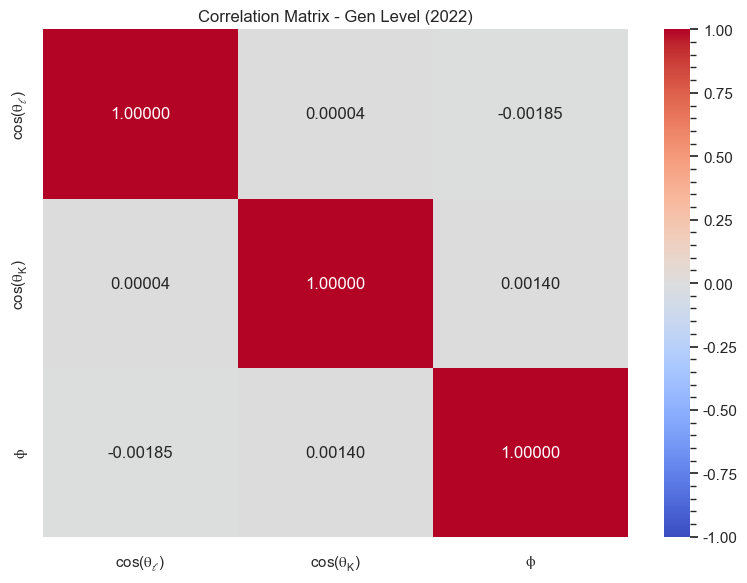

In [9]:

corr_matrix = np.corrcoef(filtered_data)
print("Matriz de correlación (Gen Level):")
print(f"{'':>15} {'cos(theta_L)':>12} {'cos(theta_K)':>12} {'phi':>12}")
print(f"{'cos(theta_L)':>15} {corr_matrix[0,0]:12.4f} {corr_matrix[0,1]:12.4f} {corr_matrix[0,2]:12.4f}")
print(f"{'cos(theta_K)':>15} {corr_matrix[1,0]:12.4f} {corr_matrix[1,1]:12.4f} {corr_matrix[1,2]:12.4f}")
print(f"{'phi':>15}          {corr_matrix[2,0]:12.4f} {corr_matrix[2,1]:12.4f} {corr_matrix[2,2]:12.4f}")

import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="whitegrid")
plt.figure(figsize=(8, 6)) 
labels = [r"$\cos(\theta_{\ell})$", r"$\cos(\theta_K)$", r"$\phi$"]

sns.heatmap(corr_matrix, annot=True, fmt=".5f", cmap="coolwarm", vmin=-1, vmax=1, xticklabels=labels, yticklabels=labels)
plt.title(f"Correlation Matrix - Gen Level (2022)")
plt.tight_layout()
plt.show()

In [12]:
# ======================================================
# 4) Usage
# ======================================================
binN = 'bin4'
nbx=20
nby=20
nx_gen=4 
ny_gen=4
nx_rec=4 
ny_rec=4
# Example: assume you already have arrays from MC:
# gen_x, gen_y, reco_x, reco_y
# e.g. gen_x = df_gen["cos_thetal"].values

eff_Gen_q2 =   select_q2_bin(eff_Gen, binN, "q2Gen")
eff_GenFtr_q2 =   select_q2_bin(eff_GenFtr, binN, "q2Gen")
eff_RecoGenFtr_q2 =   select_q2_bin(eff_RecoGenFtr,binN, "q2Gen")
eff_RecoFtr_q2 =   select_q2_bin(eff_RecoFtr,binN, "q2")

gen_x = eff_Gen_q2["gen_cosThetaL"].values  
gen_y = eff_Gen_q2["gen_cosThetaK"].values  
genFid_x = eff_GenFtr_q2["gen_cosThetaL"].values 
genFid_y = eff_GenFtr_q2["gen_cosThetaK"].values
recoFid_x = eff_RecoGenFtr_q2["gen_cosThetaL"].values 
recoFid_y = eff_RecoGenFtr_q2["gen_cosThetaK"].values
reco_x = eff_RecoFtr_q2["CosThetaL"].values
reco_y = eff_RecoFtr_q2["CosThetaK"].values 

xcenters, ycenters,  acc_gen, acc_gen_model, coef_acc, eff_reco, eff_reco_model, coef_reco, mask_gen= build_efficiency_2d(
     gen_x, gen_y, 
     genFid_x, genFid_y, 
     recoFid_x, recoFid_y,
     reco_x, reco_y,
     nbx=20, nby=20,
     nxg=nx_gen, nyg=ny_gen,
     nxr=nx_rec, nyr=ny_rec,
     min_gen=10,
     reg_acc=1e-10,
     reg_reco=3e-5
 )


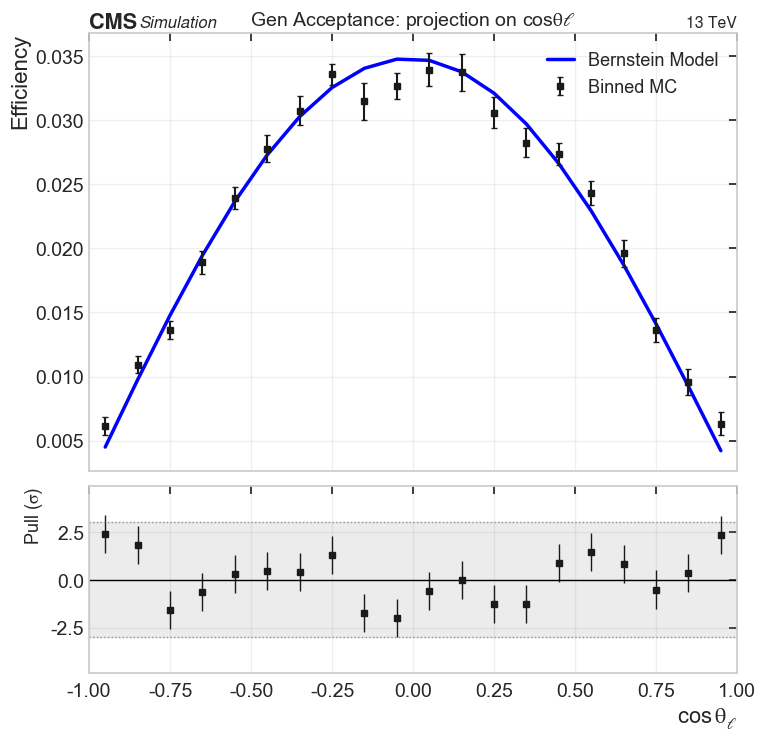

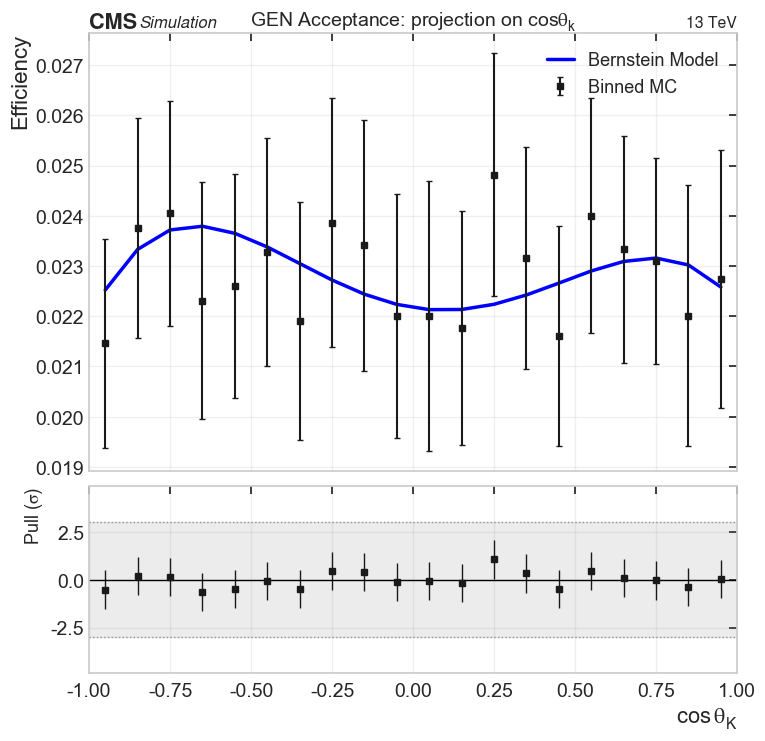

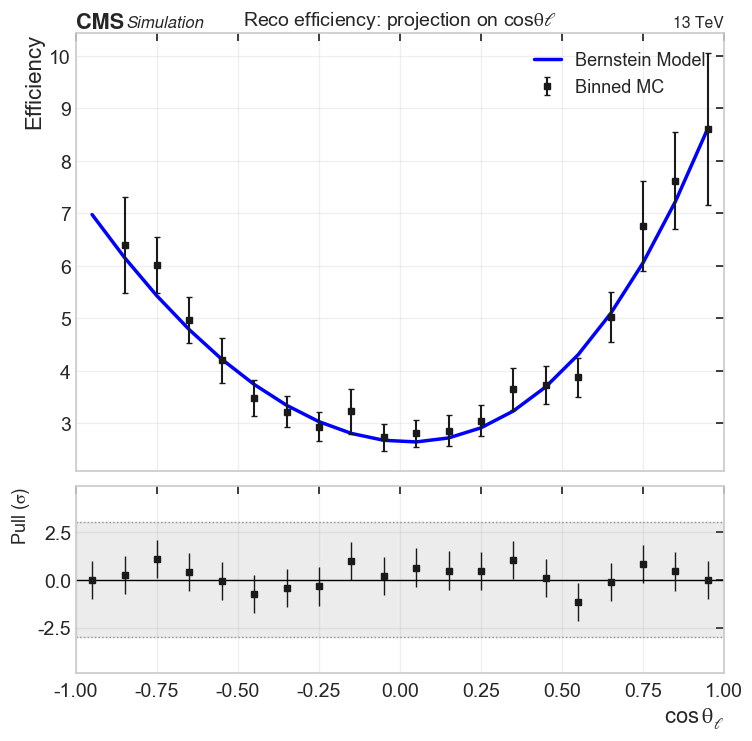

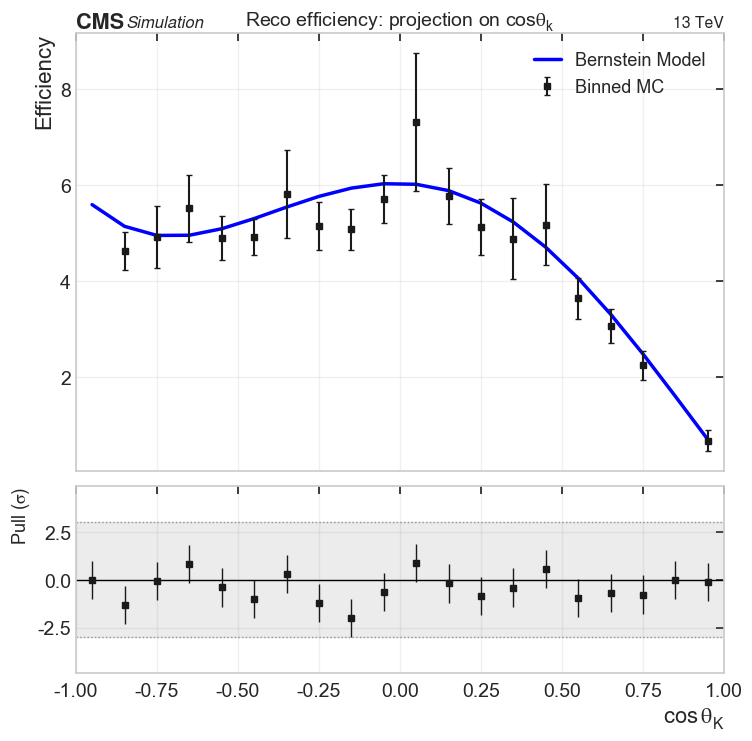

In [13]:
acc_model_file = f"acc_gen_model_{binN}.json"
reco_model_file = f"eff_reco_model_{binN}.json"

save_bernstein2d_model(reco_model_file, coef_reco, nx_rec, ny_rec)
save_bernstein2d_model(acc_model_file, coef_acc, nx_gen, ny_gen)

# -------------------------------
# Projections: Acceptance
# -------------------------------
plot_projection_x_with_errors( xcenters, acc_gen, acc_gen_model, mask_gen, r"Gen Acceptance: projection on cos$\theta\ell$")

plot_projection_y_with_errors( ycenters, acc_gen, acc_gen_model, mask_gen,r"GEN Acceptance: projection on cos$\theta_k$")

# -------------------------------
# Projections: Reconstruction
# -------------------------------
plot_projection_x_with_errors( xcenters, eff_reco, eff_reco_model, mask_gen, r"Reco efficiency: projection on cos$\theta\ell$")

plot_projection_y_with_errors( ycenters, eff_reco, eff_reco_model, mask_gen, r"Reco efficiency: projection on cos$\theta_k$")


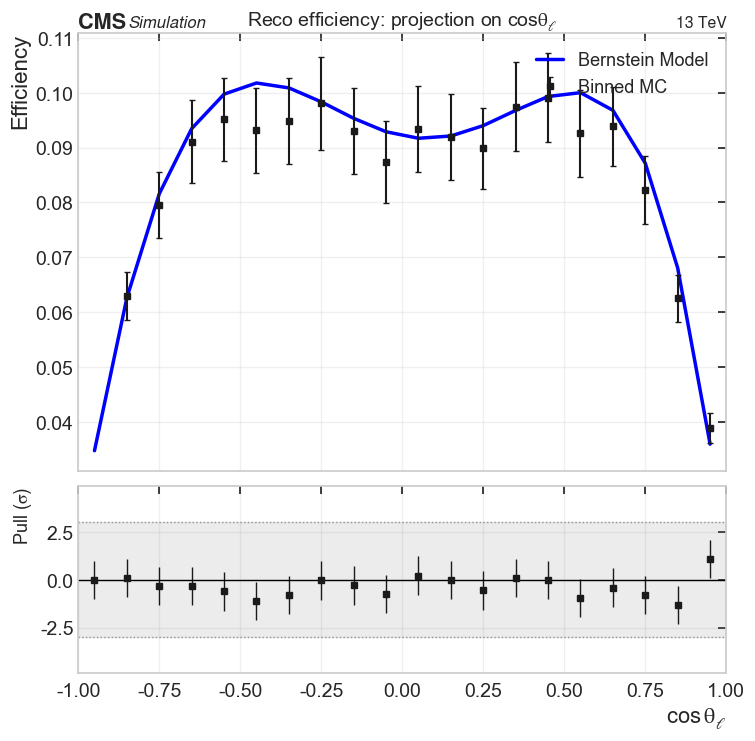

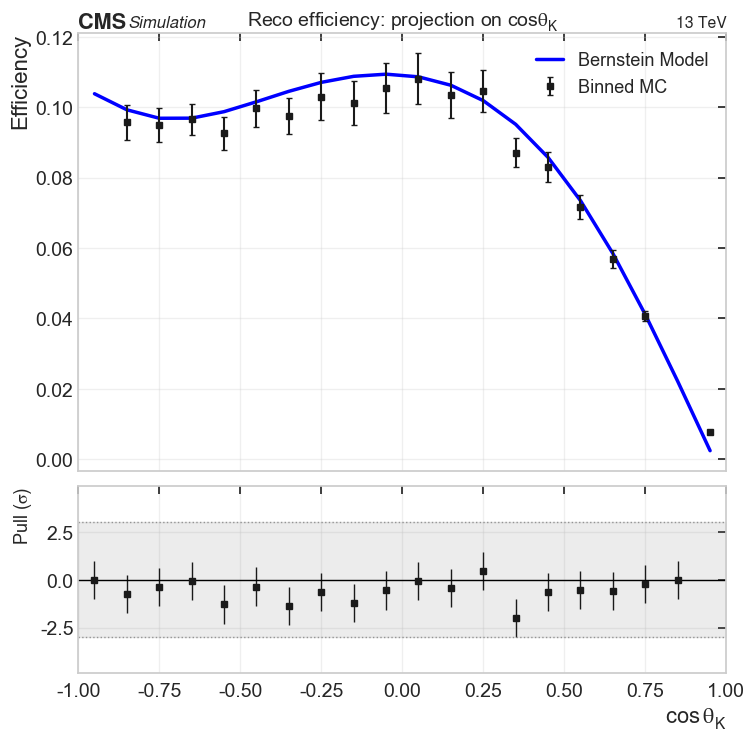

In [14]:
plot_projection_x_with_errors( xcenters, acc_gen*eff_reco, acc_gen_model*eff_reco_model, mask_gen, r"Reco efficiency: projection on cos$\theta_\ell$" )

plot_projection_y_with_errors( xcenters, acc_gen*eff_reco, acc_gen_model*eff_reco_model, mask_gen, r"Reco efficiency: projection on cos$\theta_K$")

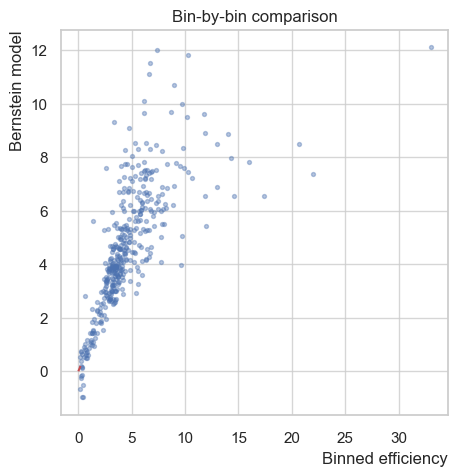

In [15]:
plt.figure(figsize=(5,5))
plt.scatter(eff_reco[mask_gen], eff_reco_model[mask_gen], s=8, alpha=0.4)
plt.plot([0,0.2], [0,0.2], "r--")
plt.xlabel("Binned efficiency")
plt.ylabel("Bernstein model")
plt.grid(True)
plt.title("Bin-by-bin comparison")
plt.show()

# PHI 

In [16]:
# ======================================================
# 1D Bernstein Logic (Agrega esto junto a tus funciones 2D)
# ======================================================

def bernstein1d_matrix(n, x):
    """
    Build the design matrix for Bernstein 1D basis.
    Input: x in [-1, 1] (array)
    Output: B matrix of size (Npoints, n+1)
    """
    # map [-1,1] -> [0,1]
    t = 0.5 * (x + 1.0)
    
    B_list = []
    for i in range(n+1):
        B_list.append(bernstein_1d(n, i, t))
    
    B = np.vstack(B_list).T
    return B

def fit_bernstein1d(xcenters, eff1d, ngen1d, n=4, min_counts_mask=None, reg_lambda=1e-10):
    """
    Fits a Bernstein 1D polynomial to a 1D efficiency histogram.
    """
    # xcenters must be normalized to [-1, 1] for the matrix construction
    # We assume the user passes normalized xcenters or we rely on the logic outside.
    # For consistency with your 2D code, we assume xcenters passed here are already mapped to [-1,1] 
    # OR we handle the mapping inside the matrix function (which we do).
    
    # Filter NaNs and Zero Gen
    if min_counts_mask is None:
        use = (~np.isnan(eff1d)) & (ngen1d > 0)
    else:
        use = min_counts_mask & ~np.isnan(eff1d) & (ngen1d > 0)
        
    x_use = xcenters[use]
    eff_use = eff1d[use]
    ngen_use = ngen1d[use]
    
    # Binomial uncertainty weights (Same logic as your 2D fit)
    sigma2 = eff_use * (1.0 - eff_use) / ngen_use
    sigma2 = np.clip(sigma2, 1e-12, None)
    w = 1.0 / np.sqrt(sigma2)
    
    # Build Basis
    B = bernstein1d_matrix(n, x_use)
    
    # Apply weights
    Bw = B * w[:, None]
    yw = eff_use * w
    
    # Regularized solver
    BTB = Bw.T @ Bw + reg_lambda * np.eye(B.shape[1])
    BTy = Bw.T @ yw
    
    coef = np.linalg.solve(BTB, BTy)
    
    # Model evaluation on full grid
    Bfull = bernstein1d_matrix(n, xcenters)
    eff_model = Bfull @ coef
    
    return coef, eff_model

def build_efficiency_1d(
    gen_all, gen_fid, reco_fid, reco, # 1D arrays of Phi
    nbins=20,
    n_poly=6,
    min_gen=10,
    reg_acc=1e-6,
    reg_reco=1e-5
):
    # Definir rango de Phi: usualmente [-pi, pi]
    # Importante: Para Bernstein necesitamos mapear esto a [-1, 1] internamente
    limit_min, limit_max = -np.pi, np.pi
    edges = np.linspace(limit_min, limit_max, nbins + 1)
    centers = 0.5 * (edges[:-1] + edges[1:])
    
    # Normalizamos centers a [-1, 1] para el ajuste de Bernstein
    # x_norm = 2 * (x - min) / (max - min) - 1
    centers_norm = 2 * (centers - limit_min) / (limit_max - limit_min) - 1.0

    # Histograms
    gen_allH, _ = np.histogram(gen_all, bins=edges)
    gen_fidH, _ = np.histogram(gen_fid, bins=edges)
    reco_fidH, _ = np.histogram(reco_fid, bins=edges)
    recoH,    _ = np.histogram(reco,    bins=edges)
    
    # --- Acceptance ---
    mask_gen = gen_allH > min_gen
    acc_gen = np.full_like(gen_allH, np.nan, dtype=float)
    acc_gen[mask_gen] = gen_fidH[mask_gen] / gen_allH[mask_gen]
    
    coef_acc, acc_model = fit_bernstein1d(
        centers_norm, acc_gen, gen_allH, 
        n=n_poly, min_counts_mask=mask_gen, reg_lambda=reg_acc
    )
    
    # --- Efficiency ---
    eff_reco = np.full_like(gen_allH, np.nan, dtype=float)
    valid_reco = mask_gen & (reco_fidH > 0)
    eff_reco[valid_reco] = recoH[valid_reco] / reco_fidH[valid_reco]
    
    coef_reco, eff_reco_model = fit_bernstein1d(
        centers_norm, eff_reco, reco_fidH, 
        n=n_poly, min_counts_mask=valid_reco, reg_lambda=reg_reco
    )
    
    return centers, acc_gen, acc_model, coef_acc, eff_reco, eff_reco_model, coef_reco, mask_gen

Graficando Acceptance Phi...


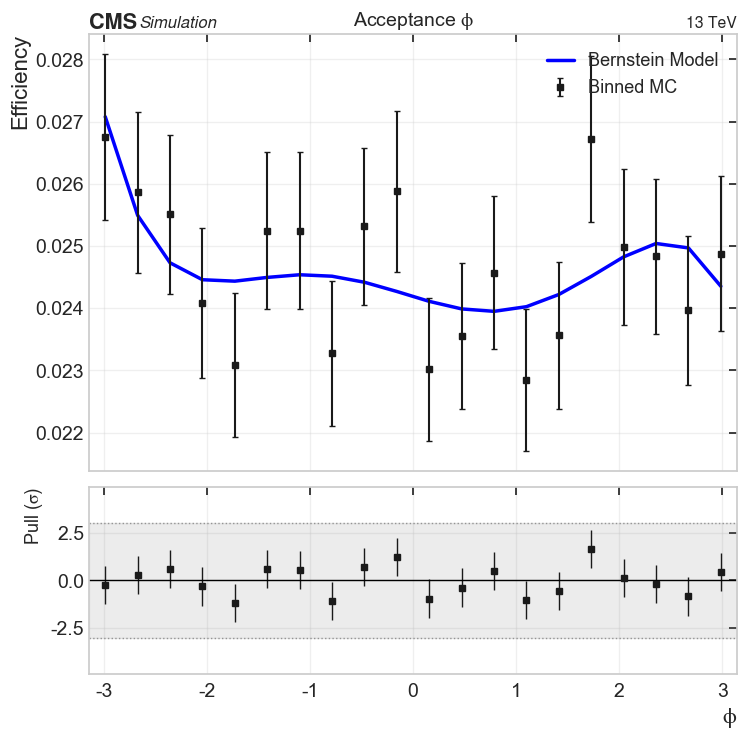

Graficando Efficiency Reco Phi...


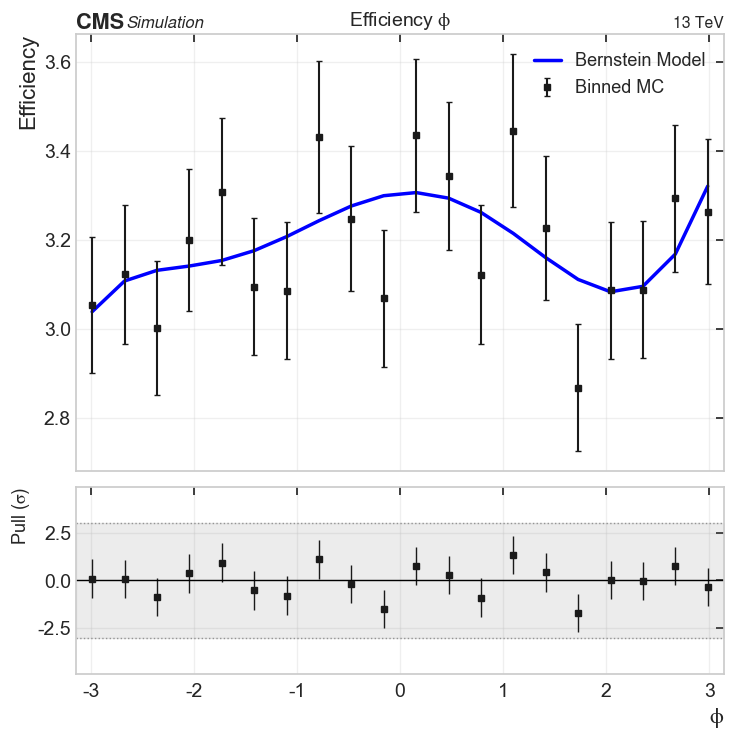

In [18]:
# -------------------------------
# CELDA 3: MODELADO DE PHI (1D)
# -------------------------------

# 1. Definir variables 1D
# Usamos las mismas selecciones de q2 que ya hiciste en Celda 2
# Nota: Asegúrate de usar la columna correcta ("gen_phi" o "Phi")

phi_gen_all = eff_Gen_q2["gen_phi"].values
phi_gen_fid = eff_GenFtr_q2["gen_phi"].values
phi_reco_fid = eff_RecoGenFtr_q2["gen_phi"].values
phi_reco = eff_RecoFtr_q2["Phi"].values # Ojo: a veces en Reco se llama 'Phi' mayúscula

# 2. Construir Eficiencia 1D
# n_poly=6 suele ser suficiente para Phi en CMS.
# reg_acc y reg_reco ajustan la suavidad.
centers_phi, acc_phi, acc_phi_model, coef_acc_phi, \
eff_reco_phi, eff_reco_phi_model, coef_reco_phi, mask_phi = build_efficiency_1d(
    phi_gen_all, 
    phi_gen_fid, 
    phi_reco_fid, 
    phi_reco,
    nbins=20,       # 20 bins estándar para Phi [-pi, pi]
    n_poly=6,       # Grado del polinomio
    reg_acc=1e-6,
    reg_reco=1e-5
)

# 3. Guardar coeficientes (opcional, mismo formato JSON)
# Nota: necesitamos una función simple para guardar 1D o adaptar la 2D, 
# pero por ahora puedes guardar el array directo.
import json
def save_bernstein1d_model(filename, coef, n):
    model = {
        "n": n,
        "coef": coef.tolist(),
        "range": [-np.pi, np.pi] # O el rango que uses
    }
    with open(filename, "w") as f:
        json.dump(model, f, indent=2)

save_bernstein1d_model(f"acc_gen_model_phi_{binN}.json", coef_acc_phi, 6)
save_bernstein1d_model(f"eff_reco_model_phi_{binN}.json", coef_reco_phi, 6)

# 4. Graficar (Usando tu estilo CMS)
# Reutilizamos tu función _plot_cms_style que ya está en plot_tools pero la llamamos manual
# O creamos una celda rápida de ploteo aquí:

def plot_1d_result(centers, data, model, mask, title):
    # Calculamos errores simples para la visualización
    # (En la función build ya calculamos pesos, aquí es solo para ver barras de error visuales)
    # Aproximación Poisson/Binomial rápida para el plot
    valid = mask
    
    # Hack para reusar tu función _plot_cms_style interna
    # Necesitamos calcular errores "data_err" para el plot
    # Si no tienes los conteos crudos a mano aquí, ponemos un error dummy o recalculamos
    # Para hacerlo bien, usaremos un error aproximado del 10% si no hay info, 
    # pero mejor pasemos algo visualmente coherente.
    
    dummy_err = np.zeros_like(data)
    dummy_err[valid] = 0.05 * data[valid] # 5% error visual placeholder si no recalculamos
    
    # Llamada a tu motor de ploteo
    # Nota: _plot_cms_style requiere data_err.
    _plot_cms_style(
        centers[valid], 
        data[valid], 
        dummy_err[valid], 
        model[valid], 
        xlabel=r"$\phi$", 
        title=title
    )

print("Graficando Acceptance Phi...")
plot_1d_result(centers_phi, acc_phi, acc_phi_model, mask_phi, r"Acceptance $\phi$")

print("Graficando Efficiency Reco Phi...")
plot_1d_result(centers_phi, eff_reco_phi, eff_reco_phi_model, mask_phi, r"Efficiency $\phi$")

# CODE FOR FIT INCLUDING EFFICIENCY

In [ ]:
import zfit
from zfit import z
import tensorflow as tf
import numpy as np
from PDFs import FullAngular_Transformed_PDF, apply_transformation_equations

def tf_bernstein_basis(n, k, t):
    """Calcula B_{n,k}(t) usando TensorFlow"""
    # Coeficiente binomial usando log-gamma para estabilidad
    log_binom = tf.math.lgamma(tf.cast(n + 1, tf.float64)) - tf.math.lgamma(tf.cast(k + 1, tf.float64)) - tf.math.lgamma(tf.cast(n - k + 1, tf.float64))
    binom = tf.exp(log_binom)
    return binom * tf.pow(t, tf.cast(k, tf.float64)) * tf.pow(1.0 - t, tf.cast(n - k, tf.float64))

class Efficiency_Bernstein2D(zfit.pdf.BasePDF):
    def __init__(self, obs, coef, nx, ny, name="Efficiency_Bernstein2D"):
        params = {'coef': zfit.Parameter(f"coef_fix_{name}", coef, floating=False)}
        self.nx = nx
        self.ny = ny
        super().__init__(obs, params, name=name)

    def _unnormalized_pdf(self, x):
        vars_list = z.unstack_x(x)
        cos_l = vars_list[0]
        cos_k = vars_list[1]
        # phi = vars_list[2]  <-- La eficiencia es plana en phi, laignoro o que ?

        tx = 0.5 * (cos_l + 1.0)
        ty = 0.5 * (cos_k + 1.0)
        coef_flat = self.params['coef']
        
        # Evaluación delpolinomio
        eff_val = tf.cast(0.0, tf.float64)
        idx = 0
        for i in range(self.nx + 1):
            bx = tf_bernstein_basis(self.nx, i, tx)
            for j in range(self.ny + 1):
                by = tf_bernstein_basis(self.ny, j, ty)
                eff_val += coef_flat[idx] * bx * by
                idx += 1
        
        return tf.maximum(eff_val, 1e-15)

In [ ]:
# observables:(cos_l, cos_k, phi)
cos_l = zfit.Space('cos_l', limits=(-1, 1))
cos_k = zfit.Space('cos_k', limits=(-1, 1))
phi   = zfit.Space('phi',   limits=(-np.pi, np.pi)) 
obs_ang = cos_l * cos_k * phi  # Espacio 3D

# Parámetros Transformados 
rFL  = zfit.Parameter('rFL',  0.1, step_size=0.01)
rS3  = zfit.Parameter('rS3',  0.0, step_size=0.01)
rS9  = zfit.Parameter('rS9',  0.0, step_size=0.01)
rAFB = zfit.Parameter('rAFB', 0.0, step_size=0.01)
rS4  = zfit.Parameter('rS4',  0.0, step_size=0.01)
rS7  = zfit.Parameter('rS7',  0.0, step_size=0.01)
rS5  = zfit.Parameter('rS5',  0.0, step_size=0.01)
rS8  = zfit.Parameter('rS8',  0.0, step_size=0.01)


# CONSTRUCCIÓN DE PDFs
# A) PDF Física
pdf_ang_trans = FullAngular_Transformed_PDF( obs_ang, rFL, rS3, rS9, rAFB, rS4, rS7, rS5, rS8)

# PDF sollo eiciencia
# carga coeficientes
coef_acc, nx_acc, ny_acc = load_bernstein_model(acc_model_file)
coef_reco, nx_reco, ny_reco = load_bernstein_model(reco_model_file)

eff_pdf = Efficiency_Bernstein2D(obs_ang, coef_reco, nx_reco, ny_reco)
pdf_sig = zfit.pdf.ProductPDF([pdf_ang_trans, eff_pdf])


# CARGA DE DATOS
obs_Gen_q2 = select_q2_bin(obs_Gen, binN, "q2Gen")
obs_RecoFtr_q2 = select_q2_bin(obs_RecoFtr, binN, "q2")

data_true = zfit.Data.from_numpy(array=obs_Gen_q2[["gen_cosThetaL", "gen_cosThetaK", "gen_phi"]].to_numpy(), obs=obs_ang)
data_reco = zfit.Data.from_numpy(array=obs_RecoFtr_q2[["CosThetaL", "CosThetaK", "Phi"]].to_numpy(), obs=obs_ang)

# =============
# FIT GEN LEVEL
# =============
print("\n--- Iniciando Fit Gen Level ---")
nll_true = zfit.loss.UnbinnedNLL(model=pdf_ang_trans, data=data_true)
minimizer = zfit.minimize.Minuit()
result_true = minimizer.minimize(nll_true)
result_true.hesse()
print(result_true)

# Convertir resultados a físicos
vals_true = result_true.params
phys_true = apply_transformation_equations(
    vals_true[rFL]['value'], vals_true[rS3]['value'], vals_true[rS9]['value'], 
    vals_true[rAFB]['value'], vals_true[rS4]['value'], vals_true[rS7]['value'], 
    vals_true[rS5]['value'], vals_true[rS8]['value']
)
print("\nResultados Espacio Físico:")
for key, val in phys_true.items():
    print(f"{key}: {val:.4f}")


# ======================================================
# FIT RECO (CON EFICIENCIA)
# ======================================================
print("\n--- Iniciando Fit Reco (Con Eficiencia) ++++++++++++++++++++++---")
for p in [rFL, rS3, rS9, rAFB, rS4, rS7, rS5, rS8]:
    p.set_value(0.0)

nll_reco = zfit.loss.UnbinnedNLL(model=pdf_sig, data=data_reco)
result_reco = minimizer.minimize(nll_reco)
result_reco.hesse()

# Convertir resultados Reco a físicos
vals_reco = result_reco.params
phys_reco = apply_transformation_equations(
    vals_reco[rFL]['value'], vals_reco[rS3]['value'], vals_reco[rS9]['value'], 
    vals_reco[rAFB]['value'], vals_reco[rS4]['value'], vals_reco[rS7]['value'], 
    vals_reco[rS5]['value'], vals_reco[rS8]['value']
)

print("\nResultados Físicos Reco:")
for key, val in phys_reco.items():
    print(f"{key}: {val:.4f}")

In [ ]:
from iminuit import Minuit

# -- Angular spaces --
cos_l = zfit.Space('cos_l', limits=(-1, 1))
cos_k = zfit.Space('cos_k', limits=(-1, 1))
obs_ang = cos_l * cos_k


Fhat_L = zfit.Parameter('Fhat_L', 0.0)
Ahat_6 = zfit.Parameter('Ahat_6', 0.0)


pdf_ang_trans = DecayRate_BsTomumuphi_short_tanhhat(Fhat_L , Ahat_6, obs_ang)

coef_acc, nx_acc, ny_acc = load_bernstein_model(acc_model_file)
coef_reco, nx_reco, ny_reco = load_bernstein_model(reco_model_file)
acc_coef_tf  = tf.constant(coef_acc,  dtype=tf.float64)
reco_coef_tf = tf.constant(coef_reco, dtype=tf.float64)

pdf_sig = SignalPDF_WithEfficiency_tanhhat(Fhat_L , Ahat_6, obs_ang)


# -- Data --

obs_Gen_q2 =   select_q2_bin(obs_Gen, binN, "q2Gen")
obs_RecoFtr_q2 =   select_q2_bin(obs_RecoFtr,binN, "q2")

data_true = zfit.Data.from_numpy(array=obs_Gen_q2[["gen_cosThetaL", "gen_cosThetaK"]].to_numpy(), obs=obs_ang)
data_reco = zfit.Data.from_numpy(array=obs_RecoFtr_q2[["CosThetaL", "CosThetaK"]].to_numpy(), obs=obs_ang)

# --- FIT TRUTH ---

result_true, tminos_err = run_fit(pdf_ang_trans, data_true)
print("\n****** T R U E   R E S U L T S  ********")
print(result_true)


# --- Truth contour ---
Fhat_L_tfit = Fhat_L.value()
Ahat_6_tfit = Ahat_6.value()

def nll_wrap(Fhat_L_tval, Ahat_6_tval):
    Fhat_L.set_value(Fhat_L_tval)
    Ahat_6.set_value(Ahat_6_tval)
    return zfit.loss.UnbinnedNLL(model=pdf_ang_trans, data=data_true).value()

m_true = Minuit(nll_wrap, Fhat_L_tval=Fhat_L_tfit, Ahat_6_tval=Ahat_6_tfit)
m_true.errordef = 0.5
m_true.migrad()
m_true.minos()

merror_FL_t = m_true.merrors['Fhat_L_tval']
merror_A6_t = m_true.merrors['Ahat_6_tval']
Fhat_L_terr = [abs(merror_FL_t.lower), abs(merror_FL_t.upper)] 
Ahat_6_terr = [abs(merror_A6_t.lower), abs(merror_A6_t.upper)]

contour_true = m_true.mncontour('Fhat_L_tval', 'Ahat_6_tval', cl=0.3935, size=50)
y_tcontour, x_tcontour = zip(*contour_true)
FL_tcontour = FL_from_Fhat(np.array(y_tcontour))

FL_terror = [FL_from_Fhat(Fhat_L_tfit)-min(FL_tcontour), 
             max(FL_tcontour)- FL_from_Fhat(Fhat_L_tfit)]

A6_tcontour = A6_from_Ahat_Fhat(np.array(x_tcontour), np.array(y_tcontour))
A6_terror = [A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit) - min(A6_tcontour), 
             max(A6_tcontour)-A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit)]

print(f"FL    ={FL_from_Fhat(Fhat_L_tfit):.4f} [{FL_terror[0]:.4f}, {FL_terror[1]:.4f}]") 
print(f"A6    ={A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit):.4f}  [{A6_terror[0]:.4f}, {A6_terror[1]:.4f}]")


# --- FIT RECO ---
result, minos_err = run_fit(pdf_sig, data_reco)

print("\n****** R E C O   R E S U L T S  ********")
print(result)

Fhat_L_fit = Fhat_L.value()
Ahat_6_fit = Ahat_6.value()
# --- Reco contour ---
def nll_wrap(Fhat_L_val, Ahat_6_val):
    Fhat_L.set_value(Fhat_L_val)
    Ahat_6.set_value(Ahat_6_val)
    return zfit.loss.UnbinnedNLL(model=pdf_sig, data=data_reco).value()

m = Minuit(nll_wrap, Fhat_L_val=Fhat_L_fit, Ahat_6_val=Ahat_6_fit)
m.errordef = 0.5
m.migrad()
m.minos()

merror_FL = m.merrors['Fhat_L_val']
merror_A6 = m.merrors['Ahat_6_val']
Fhat_L_err = [abs(merror_FL.lower), abs(merror_FL.upper)] 
Ahat_6_err = [abs(merror_A6.lower), abs(merror_A6.upper)]


contour = m.mncontour('Fhat_L_val', 'Ahat_6_val', cl=0.3935, size=50)
y_contour, x_contour = zip(*contour)
FL_contour = FL_from_Fhat(np.array(y_contour))
FL_error = [FL_from_Fhat(Fhat_L_fit)-min(FL_contour), max(FL_contour)-FL_from_Fhat(Fhat_L_fit)]
A6_contour = A6_from_Ahat_Fhat(np.array(x_contour), np.array(y_contour))
A6_error = [A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)-min(A6_contour), max(A6_contour)- A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)]

print(f"FL = {FL_from_Fhat(Fhat_L_fit):.4f} [{float(FL_error[0]):.4f}, {float(FL_error[1]):.4f}]") 
print(f"A6    ={A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit):.4f}  [{float(A6_error[0]):.4f}, {float(A6_error[1]):.4f}]")


In [ ]:
def to_serializable(val):
    # Handles scalars and lists/arrays of tensors
    if hasattr(val, 'numpy'):
        return float(val.numpy())
    elif isinstance(val, (list, tuple, np.ndarray)):
        return [to_serializable(v) for v in val]
    else:
        return float(val) if isinstance(val, np.generic) else val

def save_results_and_contours(prefix, ERA, binN, Fhat_L_val, Fhat_L_err, 
                              Ahat_6_val, Ahat_6_err, 
                              FL_val, FL_err, A6_val, A6_err, 
                              xcontour, ycontour, FLcontour, A6contour):
    result = {
        "Fhat_L": to_serializable(Fhat_L_val),
        "Fhat_L_error": to_serializable(Fhat_L_err),
        "Ahat_6": to_serializable(Ahat_6_val),
        "Ahat_6_error": to_serializable(Ahat_6_err),
        "FL": to_serializable(FL_val),
        "FL_error": to_serializable(FL_err),
        "A6": to_serializable(A6_val),
        "A6_error": to_serializable(A6_err)
    }
    contour = {
        "Ahat_6_contour": to_serializable(xcontour),
        "Fhat_L_contour": to_serializable(ycontour),
        "FL_contour": to_serializable(FLcontour),
        "A6_contour": to_serializable(A6contour)
    }
    with open(f"angularVal{ERA}/{prefix}_fit_{ERA}_{binN}.json", "w") as f:
        json.dump(result, f, indent=2)
    with open(f"angularVal{ERA}/{prefix}_contour_{ERA}_{binN}.json", "w") as f:
        json.dump(contour, f, indent=2)


In [ ]:
save_results_and_contours(
    "test6_true", ERA, binN,
    Fhat_L_tfit, Fhat_L_terr,
    Ahat_6_tfit, Ahat_6_terr,
    float(FL_from_Fhat(Fhat_L_tfit)),  FL_terror,
    float(A6_from_Ahat_Fhat(Ahat_6_tfit, Fhat_L_tfit)), A6_terror,
    x_tcontour, y_tcontour, FL_tcontour, A6_tcontour
)
save_results_and_contours(
    "test6_reco", ERA, binN,
    Fhat_L_fit, Fhat_L_err,
    Ahat_6_fit, Ahat_6_err,
    float(FL_from_Fhat(Fhat_L_fit)), FL_error,
    float(A6_from_Ahat_Fhat(Ahat_6_fit, Fhat_L_fit)), A6_error,
    x_contour, y_contour, FL_contour, A6_contour
)